In [1]:
import json
import numpy as np
import pyproj
from scipy.spatial import cKDTree
import pandas as pd
import time



In [17]:

# 1. 加载数据
with open('数据\JSON\cleaned_data.json',"r",encoding="utf-8") as f:
    houses = json.load(f)  # 格式: [{"id":1, "lon":116.4, "lat":39.9}, ...]

with open('数据\JSON\subway_stations.json',"r",encoding="utf-8") as f:
    stations = json.load(f)  # 格式: [{"id":"s1", "lon":116.4, "lat":39.9}, ...]

print(f"已加载: {len(houses)}套住宅, {len(stations)}个地铁站")


已加载: 2734套住宅, 594个地铁站


<>:2: SyntaxWarning: invalid escape sequence '\J'
<>:5: SyntaxWarning: invalid escape sequence '\J'
<>:2: SyntaxWarning: invalid escape sequence '\J'
<>:5: SyntaxWarning: invalid escape sequence '\J'
C:\Users\XXH\AppData\Local\Temp\ipykernel_83308\1740005356.py:2: SyntaxWarning: invalid escape sequence '\J'
  with open('数据\JSON\cleaned_data.json',"r",encoding="utf-8") as f:
C:\Users\XXH\AppData\Local\Temp\ipykernel_83308\1740005356.py:5: SyntaxWarning: invalid escape sequence '\J'
  with open('数据\JSON\subway_stations.json',"r",encoding="utf-8") as f:


In [ ]:

# 2. 数据转换与预处理
# 提取经纬度坐标
house_coords = np.array([(h['lng'], h['lat']) for h in houses])
station_coords = np.array([(s['longitude'], s['latitude']) for s in stations])

# 3. 坐标投影转换 (经纬度 → UTM平面坐标)
# 自动确定最佳UTM投影带 (假设城市在同一时区)
central_lon = np.mean(house_coords[:, 0])
utm_zone = int((central_lon + 180) // 6) + 1
is_north = np.mean(house_coords[:, 1]) >= 0
crs_utm = f"+proj=utm +zone={utm_zone} +{'north' if is_north else 'south'} +ellps=WGS84"

transformer = pyproj.Transformer.from_crs(
    "EPSG:4326",  # WGS84经纬度坐标系
    crs_utm,      # UTM投影坐标系
    always_xy=True
)

# 批量转换坐标
house_utm = np.array(transformer.transform(house_coords[:, 0], house_coords[:, 1])).T
station_utm = np.array(transformer.transform(station_coords[:, 0], station_coords[:, 1])).T

print(f"坐标转换完成 - 使用UTM投影带: {utm_zone}{'N' if is_north else 'S'}")

# 4. 计算最近地铁站距离 (单位: 米)
start_time = time.time()

# 构建地铁站KDTree索引
station_tree = cKDTree(station_utm)

# 批量查询最近地铁站 (返回距离和索引)
distances, station_indices = station_tree.query(house_utm, k=1)

# 转换为公里 (米 → 公里)
distances_km = distances / 1000.0

calc_time = time.time() - start_time
print(f"距离计算完成 - 用时: {calc_time:.2f}秒, 平均每套住宅: {calc_time/len(houses)*1000:.2f}毫秒")

# 5. 关联结果到原始数据
results = []
for i, house in enumerate(houses):
    nearest_station = stations[station_indices[i]]

    results.append({
        "标题": house["标题"],
        "nearest_station_id": nearest_station["line_name"],
        "station_name":nearest_station['station_name'],
        "distance_km": round(distances_km[i], 4)  # 保留4位小数
    })

# 6. 保存结果
df = pd.DataFrame(results)
df_main = pd.read_json('cleaned_data.json')
df_main['nearest_station_id'] = df['nearest_station_id']
df_main['distance_km'] = df['distance_km']
df_main["station_name"] = df["station_name"]
df_main['面积'] = df_main['面积'].str.replace('㎡', '').astype(float)
df_main["rent_per_unit"] = df_main["价格(元/月)"]/df_main['面积']
df_main.to_csv('数据\CSV\house_data.csv', index=False)

print(f"结果已保存: JSON和CSV文件各1份, 共包含{len(results)}条记录")

# 7. 统计信息
print("\n距离分布统计:")
print(f"最小距离: {np.min(distances_km):.4f} 公里")
print(f"平均距离: {np.mean(distances_km):.4f} 公里")
print(f"最大距离: {np.max(distances_km):.4f} 公里")
print(f"距离中位数: {np.median(distances_km):.4f} 公里")


坐标转换完成 - 使用UTM投影带: 51N
距离计算完成 - 用时: 0.00秒, 平均每套住宅: 0.00毫秒
结果已保存: JSON和CSV文件各1份, 共包含2734条记录

距离分布统计:
最小距离: 0.0000 公里
平均距离: 0.8656 公里
最大距离: 5.4301 公里
距离中位数: 0.6575 公里


<>:10: SyntaxWarning: invalid escape sequence '\F'
<>:10: SyntaxWarning: invalid escape sequence '\F'
C:\Users\XXH\AppData\Local\Temp\ipykernel_50224\1956054847.py:10: SyntaxWarning: invalid escape sequence '\F'
  df = pd.read_csv("数据\Final_edition_data.csv")


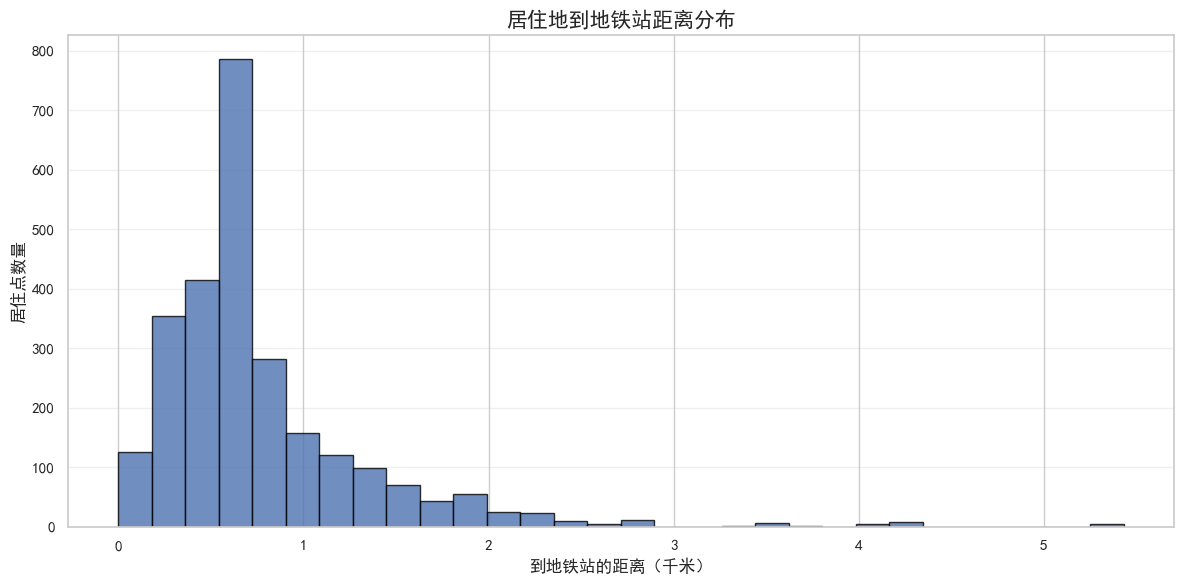

In [11]:
import matplotlib.pyplot as plt



# 设置中文显示（Windows系统需要安装SimHei字体）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
# plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 1. 读取之前保存的CSV文件
df = pd.read_csv("数据\Final_edition_data.csv")

distances = df['distance_km']  # 移除缺失值


# 2. 创建分布图
plt.figure(figsize=(12, 6))

plt.hist(distances, 
            bins= 30,  # 确保bins为正数
            color='#4C72B0', 
            edgecolor='black',
            alpha=0.8)

# 4. 添加图表标签和标题
plt.title('居住地到地铁站距离分布', fontsize=15)
plt.xlabel('到地铁站的距离（千米）', fontsize=12)
plt.ylabel('居住点数量', fontsize=12)

# 添加网格线
plt.grid(axis='y', alpha=0.3)

# 自动调整布局
plt.tight_layout()

# 5. 显示图表
plt.show()

c:\Users\XXH\python\envs\Quant\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


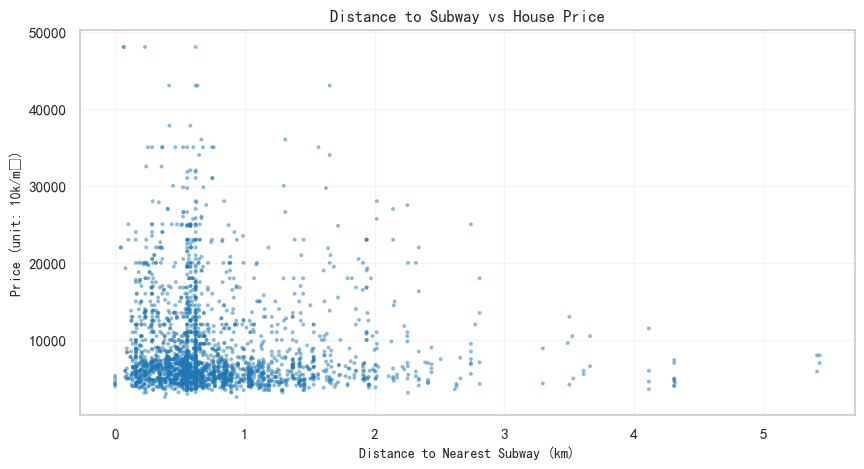

In [14]:
df_fliter= df[df["价格(元/月)"]<50000]
# 4. 纯Matplotlib绘制散点图
plt.figure(figsize=(10, 5))
plt.scatter(
    x=df_fliter['distance_km'],
    y=df_fliter["价格(元/月)"],
    s=8,           # 点大小
    alpha=0.5,     # 透明度
    c='#1f77b4',   # 标准蓝色
    edgecolors='none'
)

# 5. 仅必要装饰
plt.title('Distance to Subway vs House Price', fontsize=12)
plt.xlabel('Distance to Nearest Subway (km)', fontsize=10)
plt.ylabel('Price (unit: 10k/m²)', fontsize=10)
plt.grid(alpha=0.2)

plt.show()

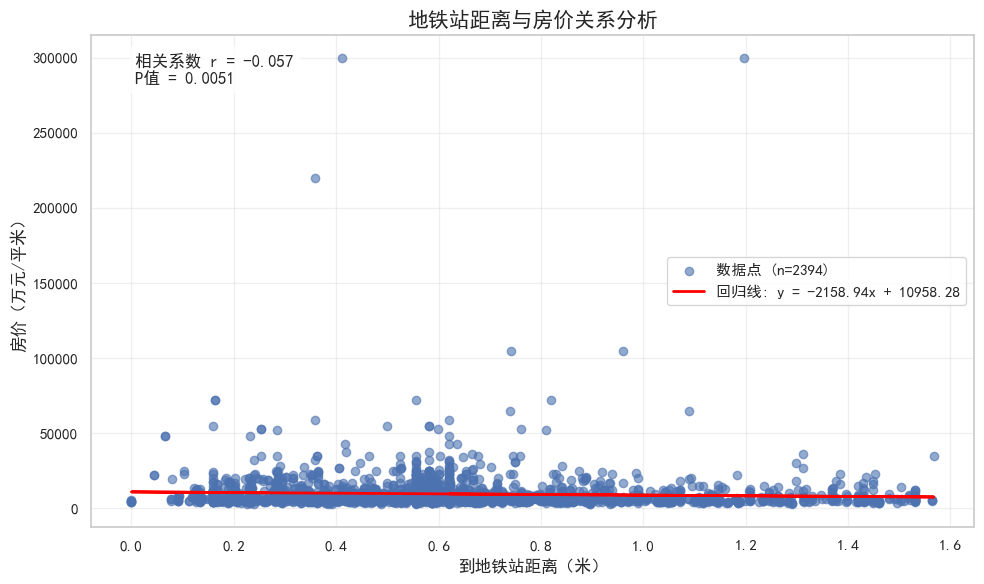


=== 详细统计结果 ===
相关系数: -0.0572 (P值: 0.0051)
回归方程: 房价 = -2158.9449 × 距离 + 10958.2776
模型R²值: 0.0033


In [19]:
data = df[['distance_km', '价格（元/月）', '面积']]  # 假设包含距离、价格、面积三列

# 按面积分组（示例分为小/中/大三组）
area_bins = [0, 90, 120, np.inf]  # 小户型(<90)、中户型(90-120)、大户型(>120)
labels = ['small', 'medium', 'large']
data['area_group'] = pd.cut(data['area'], bins=area_bins, labels=labels)

def remove_outliers_iqr(x, y):
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    mask = (x >= lower_bound) & (x <= upper_bound)
    return x[mask], y[mask]

distances, prices = remove_outliers_iqr(distances, prices)

corr_coef, p_value = stats.pearsonr(distances, prices)  # 皮尔逊相关系数
slope, intercept, r_value, p_val, std_err = stats.linregress(distances, prices)

# 3. 创建散点图和回归线
plt.figure(figsize=(10, 6))

# 散点图（添加透明度避免重叠点看不清）
plt.scatter(distances, prices, 
            alpha=0.6, 
            color='#4C72B0',
            label=f'数据点 (n={len(distances)})')

# 回归线
regression_line = slope * distances + intercept
plt.plot(distances, regression_line, 
            color='red', 
            linewidth=2,
            label=f'回归线: y = {slope:.2f}x + {intercept:.2f}')

# 4. 添加统计信息标注
plt.text(0.05, 0.9, 
            f'相关系数 r = {corr_coef:.3f}\nP值 = {p_value:.4f}',
            transform=plt.gca().transAxes,
            bbox=dict(facecolor='white', alpha=0.8))

# 5. 图表美化
plt.title('地铁站距离与房价关系分析', fontsize=15)
plt.xlabel('到地铁站距离（米）', fontsize=12)
plt.ylabel('房价（万元/平米）', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# 6. 显示图表
plt.show()

# 7. 输出详细统计结果
print("\n=== 详细统计结果 ===")
print(f"相关系数: {corr_coef:.4f} (P值: {p_value:.4f})")
print(f"回归方程: 房价 = {slope:.4f} × 距离 + {intercept:.4f}")
print(f"模型R²值: {r_value**2:.4f}")